In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
#import os, random, math, glob
#from IPython.display import Image as IM
#from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
#from time import time
#from scipy.stats import randint as sp_randint
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
#from sklearn.linear_model import SGDRegressor
#from sklearn.pipeline import Pipeline, FeatureUnion
#from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
#from sklearn.preprocessing import StandardScaler
#from tpot import TPOTRegressor

In [19]:
df = pd.read_csv('Train.csv')

In [20]:
#deleting columns with Null values
out_col = ['dw_12', 'dw_13', 'lan_13', 'pw_07', 'pw_08']
df = df.drop(out_col, 1)

#drop 'No' columnes.
no_columns = ["psa_01", "stv_01", "car_01", "lln_01"]
df = df.drop(no_columns, axis = 1)

#average number of individual in household
df['Household_Size'] = df['total_individuals']/df['total_households']

#changing type of 'ward' column to numeric
df['ward_num'] = df['ward'].apply(lambda x: x.split(":")[0])
df['ward_num'] = pd.to_numeric(df["ward_num"])

df = df.drop('ADM4_PCODE', axis=1)

In [21]:
#adding data about coordinates of cities and towns of South Africa
towns = pd.read_excel("towns.xls", index_col=None, header=None)
cities = pd.read_excel("cities.xls", index_col=None, header=None)

In [22]:
def get_dist(value, cities, towns):#
    dist_c = np.sqrt((cities[1]-value[0])**2 + (cities[2]-value[1])**2)
    dist_t = np.sqrt((towns[1]-value[0])**2 + (towns[2]-value[1])**2)
    mindist_c = dist_c.min() 
    mindist_t = dist_t.min()
    return mindist_c, mindist_t

In [23]:
#adding columns with distances to cities and towns 
df[['dist_c','dist_t']] = pd.DataFrame(df[["lat", "lon"]].apply(lambda x: get_dist(x, cities, towns), axis=1).tolist(), index=df.index)

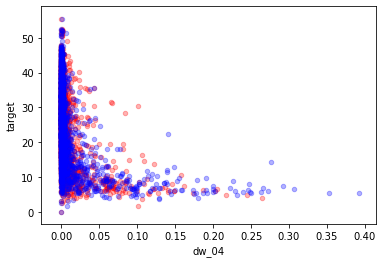

In [24]:
#dw_03 and dw_04 has similar bihavior
ax1 = df.plot(x='dw_03', y='target', kind='scatter', alpha=0.3, color='r')
ax2 = df.plot(x='dw_04', y='target', kind='scatter', alpha=0.3, color='b', ax=ax1)

In [25]:
# join 2 feature into one, maximazing them
df['dw_03_04'] = df[["dw_03", "dw_04"]].max(axis=1)
df = df.drop("dw_03", axis=1)
df = df.drop("dw_04", axis=1)

In [26]:
#split target column on 11 ranges
def get_diap(X):
    if X < 5:
        return 1
    elif X < 10 and X > 5:
        return 2
    elif X < 15 and X > 10:
        return 3
    elif X < 20 and X > 15:
        return 4 
    elif X < 25 and X > 20:
        return 5
    elif X < 30 and X > 25:
        return 6
    elif X < 35 and X > 30:
        return 7
    elif X < 40 and X > 35:
        return 8
    elif X < 45 and X > 40:
        return 9
    elif X < 50 and X > 45:
        return 10 
    elif X < 56 and X > 50:
        return 11 

In [27]:
#adding column with target diapasons to split data evenly
df["target_diap"] = df["target"].apply(lambda X: get_diap(X))
X = df[df.columns.difference(['ward', 'target', 'target_diap'])]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=750, stratify = df["target_diap"])

In [28]:
reg1 = GradientBoostingRegressor(n_estimators=600)
reg2 = linear_model.BayesianRidge(n_iter=2)
reg3 = xgb.XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=100, objective='reg:squarederror', subsample=0.55, min_child_weight=9)
vot = VotingRegressor(estimators=[('gb', reg1), ('br', reg2), ('xb', reg3)])
vot = vot.fit(X_train, y_train)